In [27]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from keras.utils import to_categorical
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D
from keras.layers import BatchNormalization, MaxPooling2D, Flatten

In [35]:
#Load dataset
df_train = pd.read_json("D:/StatoilC-CORE Iceberg Classifier Challenge/train.json/train.json")
df_train.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [3]:
#With rescaling
def prepare_data(df):
    X_band_1 = []
    X_band_2 = []
    
    for band in df["band_1"]:
        #Convert to float32
        band_1 = np.array(band).astype(np.float32)
        #Reshaping band_1 and band_2
        band_1 = band_1.reshape(75,75)
        X_band_1.append(band_1)
        
    for band in df["band_2"]:
         #Convert to float32
        band_2 = np.array(band).astype(np.float32)
        #Reshaping band_1 and band_2
        band_2 = band_2.reshape(75,75)
        X_band_2.append(band_2)
        
    #Convert list to numpy array
    X_band_1 = np.array(X_band_1)
    X_band_2 = np.array(X_band_2)
    
    # Rescale
    X_band_1 = (X_band_1 - X_band_1.mean()) / (X_band_1.max() - X_band_1.min())
    X_band_2 = (X_band_2 - X_band_2.mean()) / (X_band_2.max() - X_band_2.min())
    
    #Concatenate band_1 and band_2 to create X for training (or test)
    X = np.concatenate([X_band_1[:, :, :, np.newaxis], 
                        X_band_2[:, :, :, np.newaxis],((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], 
                        axis=-1)
    
    Y = np.array(df["is_iceberg"])
    
    return X, Y

In [6]:
X, Y = prepare_data(df_train)

print("X shape is:{}".format(X.shape))
print("Y shape is:{}".format(Y.shape))

X shape is:(1604, 75, 75, 3)
Y shape is:(1604,)


## Transfer learning using VGG16

In [13]:
SIZE = 75

# Split data to train and test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [14]:
# Normalize and reshape
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")
X_train = X_train / 255
X_test = X_test / 255

In [15]:
# One hot encoding
y_train_one_hot = to_categorical(Y_train)
y_test_one_hot = to_categorical(Y_test)

In [16]:
# Load VGG model
vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(SIZE, SIZE, 3))

In [17]:
# Make Loaded layers as non-trainable
for layer in vgg_model.layers:
    layer.trainable = False
    
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0     

In [18]:
# Now we want to use features from convolutional network (vgg16) for random forest model
feature_vgg16 = vgg_model.predict(X_train)
features = feature_vgg16.reshape(feature_vgg16.shape[0], -1)

# features extracted from vgg model is going to be X for RF
X_RF = features

### Random Forest

In [20]:
RF_model = RandomForestClassifier(n_estimators=50, random_state=42)
# Train the model
RF_model.fit(X_RF, Y_train)   # One hot encoding is just for ANN

RandomForestClassifier(n_estimators=50, random_state=42)

In [21]:
X_test_features = vgg_model.predict(X_test)
X_test_features = X_test_features.reshape(X_test_features.shape[0], -1)

# Predict the model
y_pred = RF_model.predict(X_test_features)

In [28]:
# Check accuracy
accuracy = accuracy_score(Y_test, y_pred)
print("Accuracy of Model is = ", (accuracy * 100.0), "%")

Accuracy of Model is =  74.14330218068535 %


<AxesSubplot:>

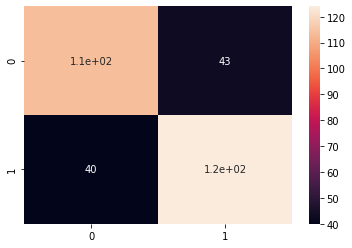

In [29]:
# Confusion matrix
cm = confusion_matrix(Y_test, y_pred)
sns.heatmap(cm, annot=True)

In [30]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.73      0.73       157
           1       0.74      0.76      0.75       164

    accuracy                           0.74       321
   macro avg       0.74      0.74      0.74       321
weighted avg       0.74      0.74      0.74       321



The prediction for this image is:  0
The actual label for this image is:  0


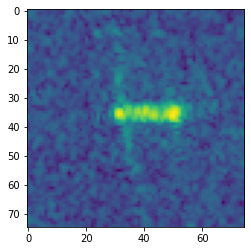

In [36]:
#Check results on a few select images
num = np.random.randint(0, X_test.shape[0])
img = X_test[num]
plt.imshow(img[:,:,0])
#Expand dimension so the input is (num images, x, y, c)
input_img = np.expand_dims(img, axis=0) 
img_feature = vgg_model.predict(input_img)
img_features = img_feature.reshape(img_feature.shape[0], -1)
y_pred = RF_model.predict(img_features)[0] 
print("The prediction for this image is: ", y_pred)
print("The actual label for this image is: ", Y_test[num])

The prediction for this image is:  1
The actual label for this image is:  1


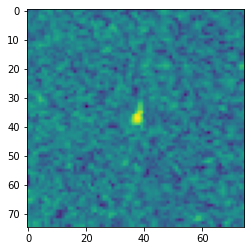

In [39]:
#Check results on a few select images
num = np.random.randint(0, X_test.shape[0])
img = X_test[num]
plt.imshow(img[:,:,0])
#Expand dimension so the input is (num images, x, y, c)
input_img = np.expand_dims(img, axis=0) 
img_feature = vgg_model.predict(input_img)
img_features = img_feature.reshape(img_feature.shape[0], -1)
y_pred = RF_model.predict(img_features)[0] 
print("The prediction for this image is: ", y_pred)
print("The actual label for this image is: ", Y_test[num])